# 로컬 개발 코드
- 로컬에서 주피터 노트북(Jupyter Notebook), 주피터 랩(JupyterLab) 또는 파이썬(Python)을 이용한다. 
- 사이킷 런(scikit-learn), 텐서플로우(tensorflow), 파이토치(pytorch)를 사용하여 딥러닝 프로그램을 개발한다.
- 파일명: 0_local_image_generation.ipynb

### 로컬 개발 워크플로우(workflow)  
- 로컬 개발 워크플로우를 다음의 4단계로 분리한다.

1. **데이터셋 준비(Data Setup)**
- 로컬 저장소에서 전처리 및 학습에 필요한 학습 데이터셋을 준비한다.

2. **데이터 전처리(Data Preprocessing)**
- 데이터셋의 분석 및 정규화(Normalization)등의 전처리를 수행한다.
- 데이터를 모델 학습에 사용할 수 있도록 가공한다.
- 추론과정에서 필요한 경우, 데이터 전처리에 사용된 객체를 meta_data 폴더 아래에 저장한다.

3. **학습 모델 훈련(Train Model)**
- 데이터를 훈련에 사용할 수 있도록 가공한 뒤에 학습 모델을 구성한다. 
- 학습 모델을 준비된 데이터셋으로 훈련시킨다.
- 정확도(Accuracy)나 손실(Loss)등 학습 모델의 성능을 검증한다.
- 학습 모델의 성능 검증 후, 학습 모델을 배포한다.
- 배포할 학습 모델을 meta_data 폴더 아래에 저장한다.

4. **추론(Inference)**
- 저장된 전처리 객체나 학습 모델 객체를 준비한다.
- 추론에 필요한 테스트 데이터셋을 준비한다.
- 배포된 학습 모델을 통해 테스트 데이터에 대한 추론을 진행한다. 

# 이미지 생성(Image Generation)
- Content Image를 Style Image의 화풍으로 이미지 생성

### 딥러닝을 이용한 이미지 생성 워크플로우(workflow)
- 1. Style Image와 Content Image의 특성에서 가중치와 손실을 계산한다.
- 2. Style Image의 화풍을 Content Image에 입혀 새로운 이미지를 생성한다.
- 3. CNN(Convolution Neural Network)을 통한 이미지 생성

### CNN기반 이미지 생성 모델
- Style Image의 스타일을 Content Image의 이미지에 전이한다.
- Content Image의 콘텐츠는 유지하되 Style Image의 화풍으로 채색한 것 같은 새로운 이미지를 생성하는 최적화 기술입니다.
- 이 과정은 출력 이미지를 콘텐츠 이미지의 콘텐츠 통계랑(statistic)과 스타일 참조 이미지의 스타일 통계량에 맞춰 최적화시킴으로써 구현됩니다.

In [1]:
# imports
import os
import numpy as np
import zipfile
from glob import glob

import tensorflow as tf
from tensorflow.python.keras import models
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

import matplotlib.pyplot as plt
from PIL import Image
import imageio

In [2]:
# Content feature을 뽑을 층
content_layers = ['block5_conv2'] 

# Style feature을 뽑을 층
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [3]:
zip_target_path = './meta_data'
os.makedirs(zip_target_path, exist_ok=True)

In [4]:
# 이미지 경로
content_path = zip_target_path + '/dataset/view.jpg'
style_path = zip_target_path + '/dataset/mountain.jpg'

## **1. 데이터셋 준비(Data Setup)**

In [5]:
# dataset.zip 파일을 dataset 폴더에 압축을 풀어준다.
zip_source_path = './dataset.zip'

extract_zip_file = zipfile.ZipFile(zip_source_path)
extract_zip_file.extractall(zip_target_path)
 
extract_zip_file.close()

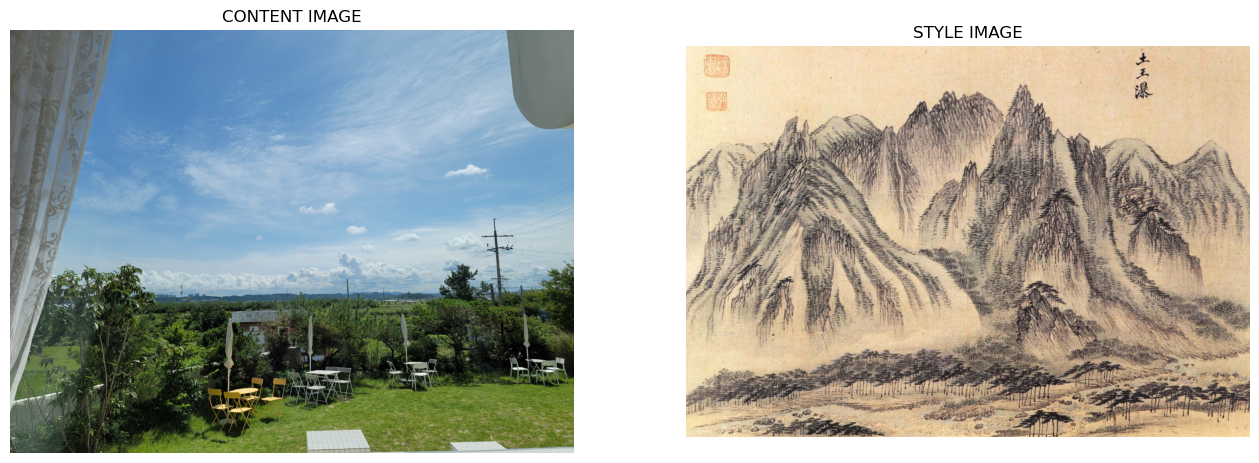

In [5]:
# 데이터 확인
plt.figure(figsize = (16, 8))

content_image = Image.open(content_path)
plt.subplot(1,2,1)
plt.imshow(content_image)
plt.title('CONTENT IMAGE')
plt.axis('off')

style_image = Image.open(style_path)
plt.subplot(1,2,2)
plt.imshow(style_image)
plt.title('STYLE IMAGE')
plt.axis('off')

plt.show()

In [6]:
# 이미지 사이즈 확인하기
content_size = Image.open(content_path).size
style_size = Image.open(style_path).size
print(content_size)
print(style_size)

(1440, 1080)
(850, 590)


## **2. 데이터 전처리(Data Preprocessing)**

- 학습을 원활하게 진행하기 위해 이미지크기를 resize하여 크기를 절반으로 줄인다. 
- content image : (1440,1080) → (720,540)
- style image : (850,590) → (425,295)
- 높은 해상도의 이미지를 낮은 해상도로 변환하면서 픽셀이 깨지는 현상을 최소화시켜주기위해 ANTIALIAS를 적용한다. 

In [7]:
# 스타일 전이 전처리
# 이미지 크기 조정, 형식 변환
def preprocessing_style_transfer(file):
    img = Image.open(file)
    img = img.resize((int(img.size[0]*0.5),int(img.size[1]*0.5)), Image.ANTIALIAS) # 이미지 크기 조정 및 왜곡 최소화
    img_array = img_to_array(img) # 이미지를 배열로 변환 
    img_array = np.expand_dims(img_array,axis=0) # 차원 추가 
    
    input_img = preprocess_input(img_array) #prepare image for model vgg19
    return input_img

## **3. 학습 모델 훈련(Train Model)**

### Style transfer : cnn모델을 이용하여 content image의 형태를 style image의 화풍으로 재생성하는 모델
- 이 예제에서는 cnn모델로 이미지 분류 네트워크 중 하나인 vgg19를 사용할 것이며,이 사전 훈련된 네트워크를 이용하여 콘텐츠 및 스타일 표현을 정의한다.
- content image와 style image를 vgg19에 input으로 넣고 **Style Reconstructions** 과 **Content Reconstructions** 과정을 거쳐 새로운 이미지를 생성한다.

#### Style Reconstructions 
- vgg19 network에 style image를 input image로 넣어 각 layer마다 style 특징을 추출하여 추출된 style image의 Gram Matrix 값과 업데이트 되는 이미지의 Gram Matrix 값을 비교한다. 
Gram Matrix는 하나의 이미지로부터 얻은 각 layer에서 feature 간의 상관관계(하나의 style에 대한 정보)를 말하며, 이 값 자체를 이미지의 style이라고 볼 수 있다.
따라서 Style Reconstructions은 두 이미지의 Gram Matrix가 유사해지도록 업데이트 하여 style 정보를 재구성하는 과정이다. 

#### Content Reconstructions
- vgg19 network에 content image를 넣어 layer층에서의 추출되는 특징 값이 재생성 되는 이미지의 특징 값과 비슷해지도록 이미지를 업데이트 하는 과정을 말한다. 


### vgg19로부터 중간 레이어의 output feature를 추출
 - 이전에 선언해둔 layer 6개{5(스타일 레이어) + 1(콘텐츠 레이어)}의 특성을 출력으로 하는 모델을 생성한다.

In [8]:
def get_model():
    vgg = VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    
    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    model_outputs = style_outputs + content_outputs

    return models.Model(vgg.input, model_outputs)

### content loss 계산
 - 생성한 모델의 중간 레이어 출력을 반환받는다.
 - 입력받은 두 이미지의 output feature 값을 비교한다.
 - content loss를 최소화 하기 위하여 역전파를 수행하고 특정 레이어(content_layer)에서 원본 콘텐츠 이미지와 유사한 응답을 생성할 때까지 초기 이미지를 변경한다.

In [9]:
def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

### style loss 계산
 - 기본 입력 이미지와 스타일 이미지를 네트워크에 제공하여 각 레이어마다 두 이미지의 gram matrix를 비교한다.
 - 각 레이어 간 gram matrix가 유사하도록 어떤 레이어에 많은 가중치를 둘 지 계산하여 style loss를 구한다.

In [10]:
# gram matrix 계산 함수
def gram_matrix(input_tensor):
    # We make the image channels first 
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

In [11]:
# 스타일 손실 계산
def get_style_loss(base_style, gram_target):
    height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)
    return tf.reduce_mean(tf.square(gram_style - gram_target))

### loss 및 weight 계산
- total loss(style loss + content loss)를 줄여주는 방향으로 가중치를 적용하여 이미지를 재생성한다. 

In [12]:
# 이미지를 로드하고 네트워크를 통해 전달하는 함수를 정의한 다음
# 모델에서 콘텐츠 및 스타일 특징 표현을 출력한다.
def get_feature_representations(model, content_path, style_path):

    content_image = preprocessing_style_transfer(content_path)
    style_image = preprocessing_style_transfer(style_path)
    
    # 원하는 콘텐츠 이미지와 기본 입력 이미지를 네트워크에 전달한다.
    # 이것은 모델의 중간에서 선택한 레이어 출력을 반환한다.
    style_outputs = model(style_image)
    content_outputs = model(content_image)
    
    # 모델의 출력(style_outputs 및 content_outputs)은
    # style_feature를 추출할 출력 5개 + content_feature를 추출할 출력 1개로 
    # 이루어져 있으므로 이를 스타일 특징, 콘텐츠 특징으로 반환한다.
    style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
    return style_features, content_features

In [13]:
# 손실 계산
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    style_weight, content_weight = loss_weights

    model_outputs = model(init_image)

    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]

    style_score = 0
    content_score = 0
    
    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
    weight_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer * get_content_loss(comb_content[0], target_content)

    style_score *= style_weight
    content_score *= content_weight

    loss = style_score + content_score 
    return loss, style_score, content_score

In [14]:
# 가중치 계산
def compute_grads(cfg):
    with tf.GradientTape() as tape: 
        all_loss = compute_loss(**cfg)

    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['init_image']), all_loss

In [15]:
# 가중치와 손실을 계산하는 과정에서 norm_means를 적용시켰던 데이터를 이미지로 변환한다.
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")
    # perform the inverse of the preprocessing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [16]:
def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=1000,
                       content_weight=1e3, 
                       style_weight=1e-2): 
    model = get_model()
    for layer in model.layers:
        layer.trainable = False
    
    # style_features 5개, content_features 1개
    style_features, content_features = get_feature_representations(model, content_path, style_path)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
    
    init_image = preprocessing_style_transfer(content_path)
    init_image = tf.Variable(init_image, dtype=tf.float32)
    
    opt = tf.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)
    
    best_loss, best_img = float('inf'), None
    
    loss_weights = (style_weight, content_weight)
    cfg = {
        'model': model,
        'loss_weights': loss_weights,
        'init_image': init_image,
        'gram_style_features': gram_style_features,
        'content_features': content_features
    }
    
    # norm_means는 불러온 모델(VGG19에 imageNet가중치)에서 학습시켰던 이미지의 채널별 픽셀 평균값이다.
    # 평균을 알면 모든 픽셀 값에서 빼서 중심이 0에 오도록 할 수 있다.
    # 이는 훈련 속도와 정확도를 높이는데 도움이 된다.
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means
    
    # 생성한 이미지 저장
    generated_images = np.expand_dims(deprocess_img(init_image.numpy()), axis=0)
    losses = []
    
    for i in range(1, num_iterations+1):
        grads, all_loss = compute_grads(cfg)
        loss, style_score, content_score = all_loss
        opt.apply_gradients([(grads, init_image)])
        # 범위를 벗어나는 값은 버린다.
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)
        if i % 10 == 0:
            image = np.expand_dims(deprocess_img(init_image.numpy()), axis=0)
            generated_images = np.concatenate((generated_images, image), axis=0)
        losses.append(loss.numpy())
    
    return generated_images, losses

In [17]:
# 상단 과정 함수화하여 실행
images, losses = run_style_transfer(content_path, 
                                    style_path, num_iterations=1000)

C:\Users\soi\anaconda3\envs\soi\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  """


In [18]:
# 변화과정 시각화
gif_dir = os.path.join('./meta_data', 'generate_images.gif')
imageio.mimsave(gif_dir, images, 'GIF', fps=10)

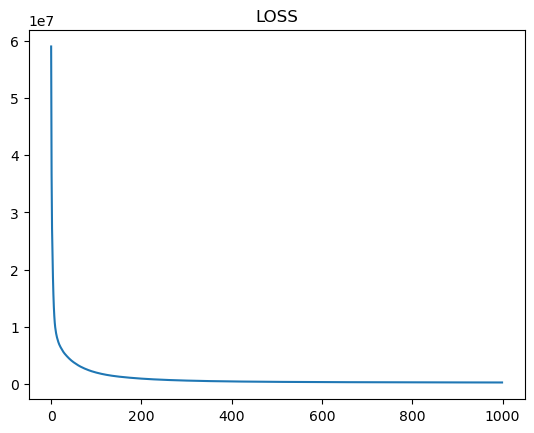

In [19]:
plt.plot(losses)
plt.title('LOSS')
plt.show()

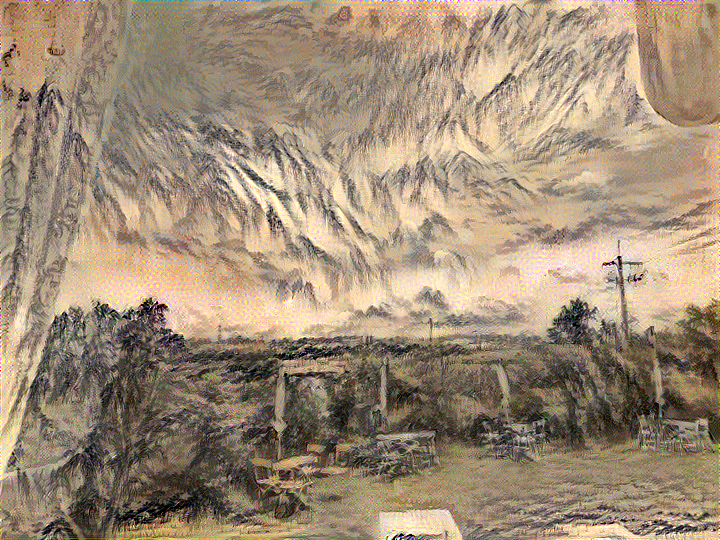

In [20]:
# style을 적용시킨 최종 content이미지
final_content = Image.fromarray(images[-1])
final_content

In [22]:
final_content.save('./meta_data/[0_local]view.jpg')

## **4. 추론(Inference)**
해당 모델의 추론은 content이미지만 변경하여 다시 학습한다.

In [22]:
zip_test_target_path = './meta_data'
os.makedirs(zip_test_target_path, exist_ok=True)

In [25]:
# test_dataset.zip 파일을 test_dataset 폴더에 압축을 풀어준다.
zip_test_source_path = './test_dataset.zip'

extract_zip_file = zipfile.ZipFile(zip_test_source_path)
extract_zip_file.extractall(zip_test_target_path)
 
extract_zip_file.close()

In [23]:
content_path = glob(os.path.join(zip_test_target_path, 'test_dataset/*.jpg'))[-1]

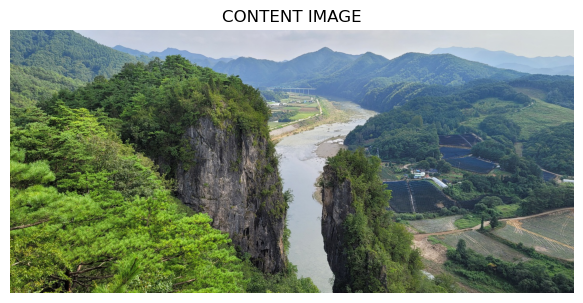

In [25]:
# 추론이미지 출력
plt.figure(figsize = (16, 8))

content_image = Image.open(content_path)
plt.subplot(1,2,1)
plt.imshow(content_image)
plt.title('CONTENT IMAGE')
plt.axis('off')

plt.show()

In [27]:
# 이미지 생성
images, losses = run_style_transfer(content_path, 
                                    style_path, num_iterations=1000)

C:\Users\soi\anaconda3\envs\soi\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  """


(720, 336)
(425, 295)
(720, 336)


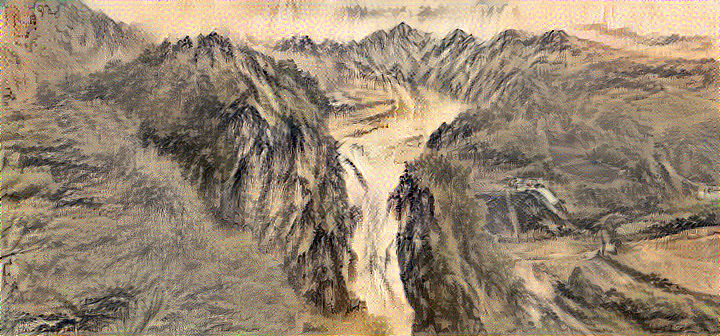

In [28]:
# 생성한 이미지 확인
inference_content = Image.fromarray(images[-1])
inference_content

In [29]:
inference_content.save('./meta_data/[0_local]river.jpg')